In [1]:
%load_ext autoreload
%autoreload 2
main_dir = r'../../..'
data_path = main_dir+'/data'
import sys
sys.path.append(main_dir)
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union

from BayDS.lib.pipeline import *
from BayDS.lib.io import *
import os


In [2]:
data_dir = f'{main_dir}/Snapshots/1/Test'
p = Pipeline(working_folder=f'{main_dir}/Snapshots/1/Dynamics')

p.add_node(LoaderNode, None, 'data',
           params={
               'input_directory': data_dir,
               'file': 'label_encoded_data.pkl'
           })
p.add_node(LoaderNode, None, 'oof',
           params={
               'input_directory': main_dir+'/Snapshots/Dynamic',
               'file': 'oof_all_data_best_lgb.csv'
           })
p.add_node(LoaderNode, None, 'predictions',
           params={
               'input_directory': main_dir+'/Snapshots/Dynamic',
               'file': 'prediction_all_data_best_lgb.csv'
           })
p.run(verbose=True)
p.save()

---------------------------
0: LoaderNode [2019-09-25 20:04:48]
params:
 {'input_directory': '../../../Snapshots/1/Test', 'file': 'label_encoded_data.pkl'}
---------------------------
1: LoaderNode [2019-09-25 20:04:52]
params:
 {'input_directory': '../../../Snapshots/Dynamic', 'file': 'oof_all_data_best_lgb.csv'}
---------------------------
2: LoaderNode [2019-09-25 20:04:52]
params:
 {'input_directory': '../../../Snapshots/Dynamic', 'file': 'prediction_all_data_best_lgb.csv'}


In [3]:
df = p.data['data']
df = df[['isFraud', 'new_card_id']]

In [4]:
pred = pd.concat([p.data['oof'].set_index('TransactionID')['isFraud'],p.data['predictions'].set_index('TransactionID')['isFraud']],axis=0)#
pred.index

Int64Index([2987000, 2987001, 2987002, 2987003, 2987004, 2987005, 2987006,
            2987007, 2987008, 2987009,
            ...
            4170230, 4170231, 4170232, 4170233, 4170234, 4170235, 4170236,
            4170237, 4170238, 4170239],
           dtype='int64', name='TransactionID', length=1097231)

In [5]:
pred

TransactionID
2987000    0.006236
2987001    0.006407
2987002    0.005103
2987003    0.001506
2987004    0.002891
             ...   
4170235    0.003395
4170236    0.003263
4170237    0.002492
4170238    0.003644
4170239    0.002183
Name: isFraud, Length: 1097231, dtype: float64

In [6]:
df['pred_0'] = pred

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
df

,isFraud,new_card_id,pred_0
TransactionID,,,
2987000,0,130935,0.006236
2987001,0,47322,0.006407
2987002,0,40076,0.005103
2987003,0,9790,0.001506
2987004,0,113643,0.002891
...,...,...,...
4170235,-1,21517,0.003395
4170236,-1,9161,0.003263
4170237,-1,48339,0.002492


In [8]:
train = df[df.isFraud >=0 ]


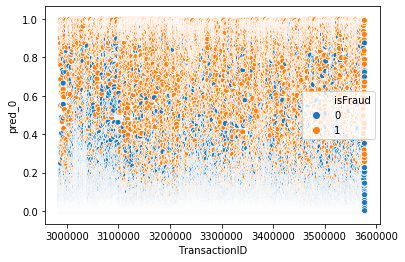

In [13]:
import seaborn as sns
sns.scatterplot(x = 'TransactionID', y='pred_0',hue='isFraud',data=train.reset_index())

In [9]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(train.isFraud, train.pred_0, pos_label=1)

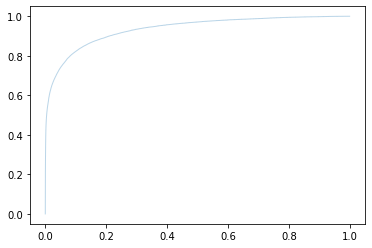

In [19]:
import matplotlib.pyplot as plt
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.3,
         label='ROC (AUC = %0.2f)' % ( roc_auc))

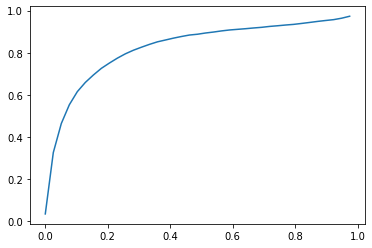

In [12]:
l = np.linspace(0,1,40)
vals = []
for i,x1 in enumerate(l):
#     if i == len(l) - 1:
#         break
#     x2 = l[i+1]
    val = train[ train.pred_0 > x1].isFraud.mean()
    vals.append(val)
#     print(x1,l[i+1], val)
plt.plot(l,vals)

In [40]:
cutoff = 0.3
true_positives = train[train.pred_0 >= cutoff][train.isFraud == 1]
false_positives = train[train.pred_0 >= cutoff][train.isFraud == 0]
false_negatives = train[train.pred_0 < cutoff][train.isFraud == 1]
true_negatives = train[train.pred_0 < cutoff][train.isFraud == 0]
print(f'TP: {len(true_positives)}, FP: {len(false_positives)}')
print(f'FN: {len(false_negatives)}, TN: {len(true_negatives)}')

TP: 10108, FP: 2201
FN: 10555, TN: 567676


c:\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
c:\python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
c:\python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [43]:
false_negatives.to_pickle(p.working_folder+'/false_negatives_index.pkl')
false_positives.to_pickle(p.working_folder+'/false_positives.pkl')